##Dependencies

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q -U datasets
!pip install fsspec==2024.10.0
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install --upgrade transformers
!pip install --upgrade bitsandbytes
!pip install --upgrade accelerate
!pip install datasets
!pip install peft

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.10.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 25.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.10.0
    Uninstalling accelerate-1.10.0:
      Succes

In [ ]:
!rm -f *.csv

In [ ]:
import os
import random
import functools
import csv
import re
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import files
from google.colab import userdata
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import Dataset, DatasetDict




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

##Environment setup

In [ ]:

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

In [ ]:
def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

In [ ]:
set_all_seeds(49)

In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


## LOAD AND PROCESS DATASET

In [ ]:
print("Please upload files for cyb_test")
cyb_test= files.upload()
cyb_test= next(iter(cyb_test))
cyb_test=pd.read_csv(cyb_test)

Please upload files for cyb_test


Saving cyb_test.csv to cyb_test.csv


In [ ]:
cyb_test.head()

,text,label
0,By the transitive property of social math bein...,age
1,But have you ever had kibble on WEEEEEEED? [URL],other_cyberbullying
2,Like this before I showed up!! And how its goi...,religion
3,Can I joke about ? Gay people? Blacks? Giraffe...,gender
4,Her twitter gone het stormed !!! RT [USER] Eat...,ethnicity


In [ ]:
print(cyb_test.isnull().sum())

text     0
label    0
dtype: int64


In [ ]:
# Display label distribution
cyb_test.label.value_counts()

,count
label,
age,1199
religion,1198
gender,1196
ethnicity,1194
not_cyberbullying,1192
other_cyberbullying,1173


In [ ]:
id2label = {0: "age",
 1: "religion",
 2: "gender",
 3: "ethnicity",
 4: "not_cyberbullying",
 5: "other_cyberbullying"}

label2id = {v: k for k, v in id2label.items()}

In [ ]:

cyb_test['label_id'] = cyb_test['label'].map(label2id)


In [ ]:
cyb_test.head()

,text,label,label_id
0,By the transitive property of social math bein...,age,0
1,But have you ever had kibble on WEEEEEEED? [URL],other_cyberbullying,5
2,Like this before I showed up!! And how its goi...,religion,1
3,Can I joke about ? Gay people? Blacks? Giraffe...,gender,2
4,Her twitter gone het stormed !!! RT [USER] Eat...,ethnicity,3


In [ ]:
cyb_test = cyb_test.drop(['label'], axis=1)

# Rename the remaining columns
cyb_test= cyb_test.rename(columns={'label_id': 'label'})

# Display the modified DataFrame
print("Modified DataFrame:")
display(cyb_test.head())

Modified DataFrame:


,text,label
0,By the transitive property of social math bein...,0
1,But have you ever had kibble on WEEEEEEED? [URL],5
2,Like this before I showed up!! And how its goi...,1
3,Can I joke about ? Gay people? Blacks? Giraffe...,2
4,Her twitter gone het stormed !!! RT [USER] Eat...,3


In [ ]:
cyb_test.reset_index(drop=True)


,text,label
0,By the transitive property of social math bein...,0
1,But have you ever had kibble on WEEEEEEED? [URL],5
2,Like this before I showed up!! And how its goi...,1
3,Can I joke about ? Gay people? Blacks? Giraffe...,2
4,Her twitter gone het stormed !!! RT [USER] Eat...,3
...,...,...
7147,FUCK THIS DUMB BLACK NIGGER . fuck FIFA,3
7148,a girl that bullied me in high school called m...,0
7149,Disgusting show by Joe Kelly. He is an school ...,0
7150,[URL] a middle school bully trying to convince...,0


## Define Model

In [ ]:
model_name = "google/gemma-2-2b-it"
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)
# text generative model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    attn_implementation='eager',
    device_map="auto",
    quantization_config=quant_config,
    dtype=torch.float16,
    num_labels=6,
)

model.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(model_name, token=my_secret_key)
if tokenizer.pad_token is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id
  tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

##Define zero-shot Prompt

In [ ]:
def generate_prompt_unified(text, examples=None):
    """
    Unified prompt generator that handles both zero-shot and few-shot cases

    Args:
        text (str): The text to be classified
        examples (list, optional): List of tuples containing (example_text, classification)
                                 If None, generates zero-shot prompt
                                 If provided, generates few-shot prompt
    """
    base_prompt = """You are a strict cyber bullying text classifier. Classify text by PRIMARY target group:

- 0 = age: School bullying, age-based attacks
- 1 = religion: Attacks on religious groups/beliefs
- 2 = gender: Sexism, homophobia, rape jokes
- 3 = ethnicity: Racism, racial slurs
- 4 = not_cyberbullying: Normal conversation
- 5 =  other_cyberbullying: General harassment

**Instructions:**
- **ONLY** return the number (0, 1, 2, 3, 4, or 5)
- **DO NOT** provide explanations, notes, or additional text
- **DO NOT** rephrase or modify the classification"""

    if examples is not None and len(examples) > 0:
        examples_section = "\n\nExamples:\n"
        for example_text, classification in examples:
            examples_section += f'Text: "{example_text}" → {classification}\n'
        examples_section += "\n"
    else:
        # Zero-shot case - no examples
        examples_section = "\n\n"

    # Final prompt assembly
    final_prompt = f"""{base_prompt}{examples_section}Text: "{text}"

CLASSIFICATION:"""

    return final_prompt

##Evaluation with test Dataset

In [ ]:
def predict(texts, model, tokenizer, prompt_generator,examples, batch_size=8):
    """
    Make predictions on a batch of texts using the specified model

    Args:
        texts: List of texts to classify
        model: The language model
        tokenizer: The tokenizer
        prompt_generator: Function to generate prompts (zero-shot or few-shot)
        examples: List of example tuples for few-shot (optional)
        batch_size: Batch size for processing
    """
    predictions = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        batch_predictions = []

        for text in batch_texts:

            prompt = prompt_generator(text, examples)

            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = inputs.to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=5,
                    num_return_sequences=1,
                    temperature=0.1,
                    top_p=0.95,
                    do_sample=True,
                    pad_token_id=tokenizer.eos_token_id
                )

            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            matches = re.findall(r'\d+', generated_text)
            if matches and int(matches[-1]) in [0, 1, 2, 3, 4, 5]:
                prediction = int(matches[-1])
            else:
                prediction = 4

            batch_predictions.append(prediction)

        predictions.extend(batch_predictions)

    return np.array(predictions)

In [ ]:
def evaluate_dataset(y_true, y_pred, dataset_name):
    """Evaluate model performance for a specific dataset"""
    print(f"\nResults for {dataset_name}:")

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    target_names = ["age", "religion", "gender", "ethnicity", "not_cyberbullying", "other_cyberbullying"]


    report = classification_report(
        y_true,
        y_pred,
        labels=[0, 1, 2, 3, 4, 5],
        target_names=target_names
    )
    print('\nClassification Report:')
    print(report)


    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])


    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': conf_matrix
    }

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device ID: {current_device}")
    print(f"Current CUDA device name: {torch.cuda.get_device_name(current_device)}")

    device = next(model.parameters()).device
    print(f"Model is on device: {device}")

    if isinstance(model, torch.nn.DataParallel):
        print(f"DataParallel is using devices: {model.device_ids}")
else:
    print("CUDA is not available")


CUDA available: True
Current CUDA device ID: 0
Current CUDA device name: NVIDIA A100-SXM4-40GB
Model is on device: cuda:0


In [ ]:
def process_single_dataset(data, model, tokenizer, dataset_name, prompt,examples=None):
    """
    Process a single dataset and return results without applying class weights.

    Args:
        data: Dictionary containing train, val, test datasets
        model: The language model to use for predictions
        tokenizer: The tokenizer for the model
        dataset_name: Name of the dataset for reporting
        prompt: Function to generate prompts from text

    Returns:
        Tuple of (results_dataframe, evaluation_results)
    """
    print(f"\nProcessing {dataset_name}...")

    x_test = data['text'].values
    y_test = data['label'].values

    test_predictions = predict(x_test, model, tokenizer, prompt,examples=examples)

    results_df = pd.DataFrame({
        'text': x_test,
        'true_label': y_test,
        'predicted_label': test_predictions
    })

    evaluation_results = evaluate_dataset(y_test, test_predictions, dataset_name)

    results_df.to_csv(f'classification_results_{dataset_name}.csv', index=False)

In [ ]:
cyb_test.head()

,text,label
0,By the transitive property of social math bein...,0
1,But have you ever had kibble on WEEEEEEED? [URL],5
2,Like this before I showed up!! And how its goi...,1
3,Can I joke about ? Gay people? Blacks? Giraffe...,2
4,Her twitter gone het stormed !!! RT [USER] Eat...,3



Processing cyber_bullying...


100%|██████████| 894/894 [52:03<00:00,  3.49s/it]



Results for cyber_bullying:
Accuracy: 0.183

Classification Report:
                     precision    recall  f1-score   support

                age       0.09      0.00      0.00      1199
           religion       0.89      0.15      0.25      1198
             gender       0.58      0.01      0.02      1196
          ethnicity       0.71      0.01      0.03      1194
  not_cyberbullying       0.37      0.43      0.39      1192
other_cyberbullying       0.11      0.50      0.18      1173

           accuracy                           0.18      7152
          macro avg       0.46      0.18      0.15      7152
       weighted avg       0.46      0.18      0.15      7152



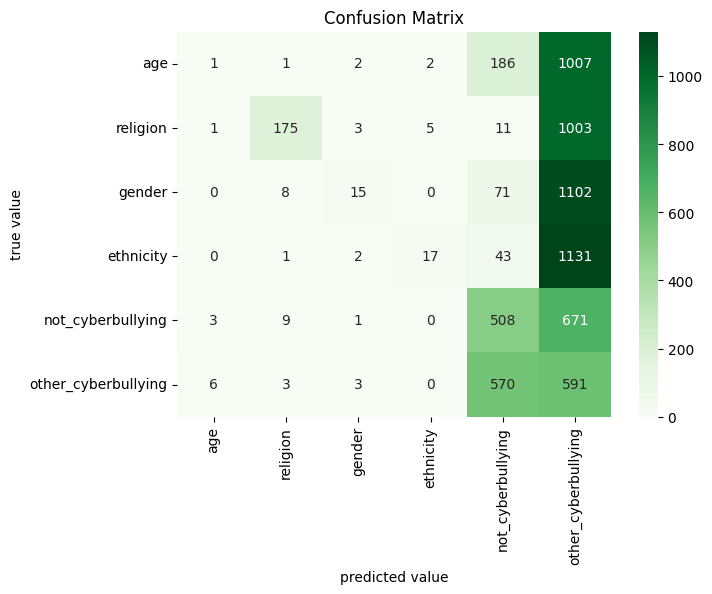

In [ ]:
model_copy=model
process_single_dataset(cyb_test, model_copy, tokenizer, 'cyber_bullying',generate_prompt_unified)

In [ ]:
few_shot_examples = [
   ("Old people like you don't belong on social media", 0),
    ("You're just a dumb kid, grow up first", 0),
   ("Shut up boomer, you're too old to understand", 0),
    ("Muslims are all terrorists who hate America", 1),
    ("Christians are brainwashed idiots who believe in fairy tales", 1),
   ("Muslims will know about every riots because they are the ones who start riots", 1),
    ("Women are too weak and emotional to be leaders", 2),
    ("Real men don't act like sensitive crybabies", 2),
   ("Prison gay rape jokes are not funny. Rape is rape", 2),
    ("Go back to Mexico where you belong, illegal", 3),
    ("Black people are all criminals and thugs", 3),
    ("Eat a fuckin dick cracker FUCK OBAMA dumb ass nigger", 3),
    ("I really enjoyed the concert last night", 4),
    ("Does anyone know what time the meeting starts?", 4),
   ("I love this song so much", 4),
    ("You're worthless and everyone thinks you're pathetic", 5),
    ("Nobody likes you and you should just disappear", 5),
    ("Everyone hates you and thinks you're stupid", 5)
]


Processing cyber bullying...


100%|██████████| 894/894 [54:07<00:00,  3.63s/it]



Results for cyber bullying:
Accuracy: 0.215

Classification Report:
                     precision    recall  f1-score   support

                age       0.75      0.01      0.01      1199
           religion       0.86      0.01      0.01      1198
             gender       0.80      0.09      0.17      1196
          ethnicity       0.62      0.30      0.40      1194
  not_cyberbullying       0.36      0.57      0.44      1192
other_cyberbullying       0.09      0.33      0.14      1173

           accuracy                           0.22      7152
          macro avg       0.58      0.22      0.19      7152
       weighted avg       0.58      0.22      0.19      7152



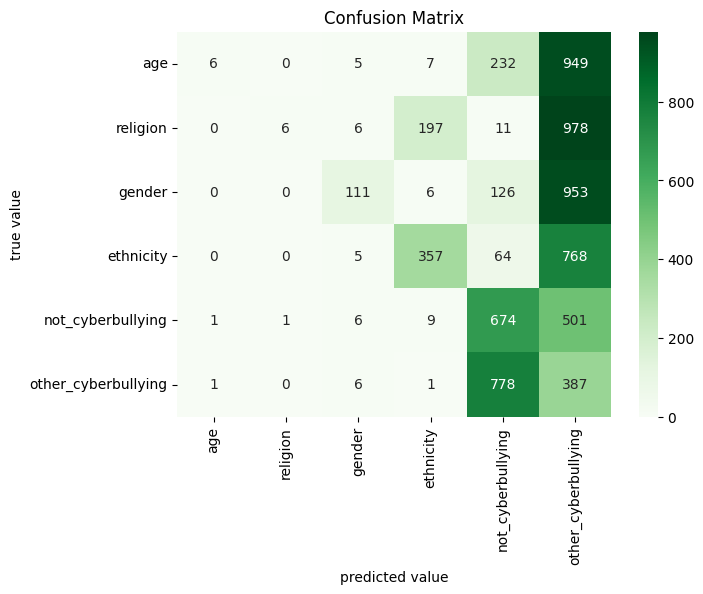

In [ ]:
model_copy=model
process_single_dataset(cyb_test, model_copy, tokenizer, 'cyber bullying',generate_prompt_unified,few_shot_examples)